# Hierarchical Forecast

This notebook offers a step by step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `NeuralForecast` and `HINT` class, to create fit, predict and reconcile forecasts.

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline<br>
1. Installing packages<br>
2. Load hierarchical dataset<br>
3. Fit and Predict HINT<br>
4. Benchmark methods<br>
5. Forecast Evaluation

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/HierarchicalNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing packages

In [ ]:
%%capture
!pip install datasetsforecast hierarchicalforecast neuralforecast statsforecast

## 2. Load hierarchical dataset

This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), although other sources are available.

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


In [ ]:
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from neuralforecast.utils import augment_calendar_df
from utilsforecast.plotting import plot_series

In [ ]:
# Load hierarchical dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df, _ = augment_calendar_df(df=Y_df, freq='M')
S_df = S_df.reset_index(names="unique_id")

Mathematically a hierarchical multivariate time series can be denoted by the vector $\mathbf{y}_{[a,b],t}$ defined by the following aggregation constraint:

$$
\mathbf{y}_{[a,b],t}  = \mathbf{S}_{[a,b][b]} \mathbf{y}_{[b],t} \quad \Leftrightarrow \quad 
\begin{bmatrix}\mathbf{y}_{[a],t}
\\ %\hline
\mathbf{y}_{[b],t}\end{bmatrix} 
= \begin{bmatrix}
\mathbf{A}_{[a][b]}\\ %\hline
\mathbf{I}_{[b][b]}
\end{bmatrix}
\mathbf{y}_{[b],t}
$$

where $\mathbf{y}_{[a],t}$ are the aggregate series, $\mathbf{y}_{[b],t}$ are the bottom level series and $\mathbf{S}_{[a,b][b]}$ are the hierarchical aggregation constraints.

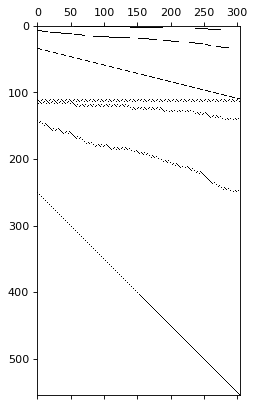

In [ ]:
# Here we plot the hierarchical constraints matrix
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

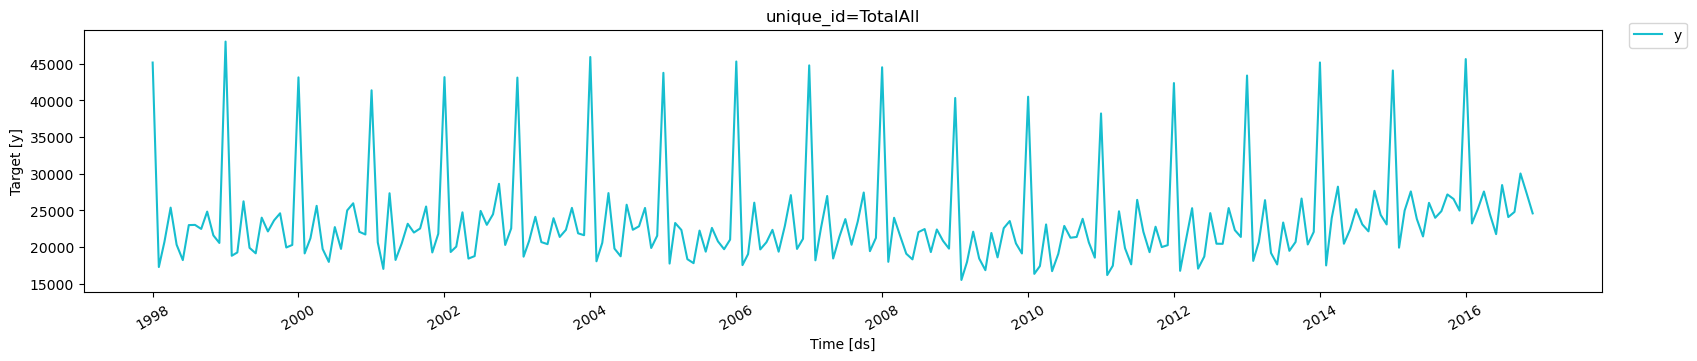

In [ ]:
plot_series(forecasts_df=Y_df[["unique_id", "ds", "y"]], ids=['TotalAll'])

## 3. Fit and Predict HINT

The Hierarchical Forecast Network (HINT) combines into an easy to use model three components:<br>
1. SoTA neural forecast model.<br> 
2. An efficient and flexible multivariate probability distribution.<br>
3. Builtin reconciliation capabilities.<br>

In [ ]:
import logging

import numpy as np

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, HINT
from neuralforecast.losses.pytorch import GMM, sCRPS

In [ ]:
# Train test splits
horizon = 12
Y_test_df  = Y_df.groupby('unique_id', observed=True).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

In [ ]:
# Horizon and quantiles
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] if lv!=0 else [50] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

# HINT := BaseNetwork + Distribution + Reconciliation
nhits = NHITS(h=horizon,
              input_size=24,
              loss=GMM(n_components=10, quantiles=quantiles),
              hist_exog_list=['month'],
              max_steps=2000,
              early_stop_patience_steps=10,
              val_check_steps=50,
              scaler_type='robust',
              learning_rate=1e-3,
              valid_loss=sCRPS(quantiles=quantiles))

model = HINT(h=horizon, S=S_df.drop(columns='unique_id').values,
             model=nhits,  reconciliation='BottomUp')

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [ ]:
%%capture
Y_df['y'] = Y_df['y'] * (Y_df['y'] > 0)
nf = NeuralForecast(models=[model], freq='MS')
nf.fit(df=Y_train_df, val_size=12)
Y_hat_df = nf.predict()

Y_hat_df = Y_hat_df.rename(columns=lambda x: x.replace('.0', ''))

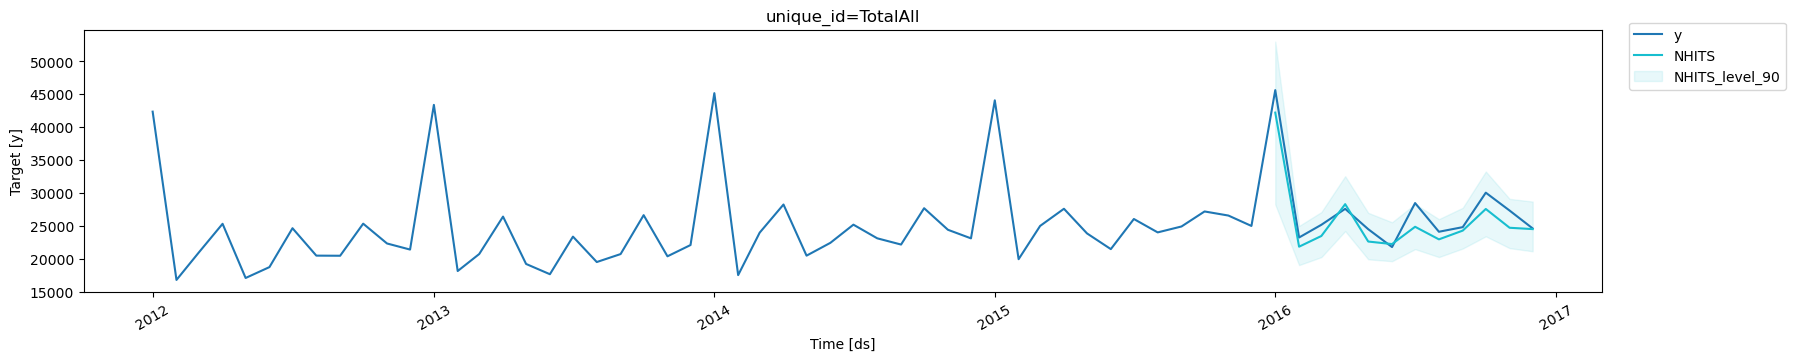

In [ ]:
plot_series(
    Y_df,
    Y_hat_df.drop(columns='NHITS-median'),
    ids=['TotalAll'],
    level=[90],
    max_insample_length=12*5,
)

## 4. Benchmark methods

We compare against AutoARIMA, a well-established traditional forecasting method from the [StatsForecast](../../../statsforecast/index) package, for which we reconcile the forecasts using [HierarchicalForecast](../../../hierarchicalforecast/index).

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

We define the model, and create the forecasts.

In [ ]:
sf = StatsForecast(models=[AutoARIMA()], 
                     freq='MS', n_jobs=-1)
Y_hat_df_arima = sf.forecast(df=Y_train_df, 
                             h=12, 
                             fitted=True, 
                             X_df=Y_test_df.drop(columns="y"), 
                             level = np.arange(2, 100, 2))
Y_fitted_df_arima = sf.forecast_fitted_values()

Next, we reconcile the forecasts using `BottomUp` and `MinTrace` reconciliation techniques:

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df_arima, 
                          Y_df=Y_fitted_df_arima, 
                          S=S_df, 
                          tags=tags, 
                          level = np.arange(2, 100, 2), 
                          intervals_method="bootstrap")

## 5. Forecast Evaluation

To evaluate the coherent probabilistic predictions we use the scaled Continuous Ranked Probability Score (sCRPS), defined as follows:

$$
\mathrm{CRPS}(\hat{F}_{[a,b],\tau},\mathbf{y}_{[a,b],\tau}) = 
    \frac{2}{N_{a}+N_{b}} \sum_{i} \int^{1}_{0} \mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q} dq
$$

$$
\mathrm{sCRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau}) = 
    \frac{\mathrm{CRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau})}{\sum_{i} | y_{i,\tau} |}
$$

As you can see the HINT model (using NHITS as base model) efficiently achieves state of the art accuracy under minimal tuning.

In [ ]:
from utilsforecast.losses import scaled_crps
from hierarchicalforecast.evaluation import evaluate

In [ ]:
df_metrics = Y_hat_df.merge(Y_test_df.drop(columns="month"), on=['unique_id', 'ds'])
df_metrics = df_metrics.merge(Y_rec_df, on=['unique_id', 'ds'])

metrics = evaluate(df = df_metrics,
                    tags = tags,
                    metrics = [scaled_crps],
                    models= ["NHITS", "AutoARIMA"],
                    level = np.arange(2, 100, 2),
                    train_df = Y_train_df.drop(columns="month"),
                    )

metrics

,level,metric,NHITS,AutoARIMA
0,Country,scaled_crps,0.044431,0.131136
1,Country/State,scaled_crps,0.063411,0.147516
2,Country/State/Zone,scaled_crps,0.106060,0.174071
3,Country/State/Zone/Region,scaled_crps,0.151988,0.205654
4,Country/Purpose,scaled_crps,0.075821,0.133664
5,Country/State/Purpose,scaled_crps,0.114674,0.181850
6,Country/State/Zone/Purpose,scaled_crps,0.180491,0.244324
7,Country/State/Zone/Region/Purpose,scaled_crps,0.245466,0.310656
8,Overall,scaled_crps,0.122793,0.191109


## References

- [Kin G. Olivares, David Luo, Cristian Challu, Stefania La Vattiata, Max Mergenthaler, Artur Dubrawski (2023). "HINT: Hierarchical Mixture Networks For Coherent Probabilistic Forecasting". International Conference on Machine Learning (ICML). Workshop on Structured Probabilistic Inference & Generative Modeling. Available at https://arxiv.org/abs/2305.07089.](https://arxiv.org/abs/2305.07089)<br />
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2023)."Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". International Journal Forecasting, accepted paper. URL https://arxiv.org/pdf/2110.13179.pdf.](https://arxiv.org/pdf/2110.13179.pdf)<br />
- [Kin G. Olivares, Federico Garza, David Luo, Cristian Challu, Max Mergenthaler, Souhaib Ben Taieb, Shanika Wickramasuriya, and Artur Dubrawski (2023). "HierarchicalForecast: A reference framework for hierarchical forecasting". Journal of Machine Learning Research, submitted. URL https://arxiv.org/abs/2207.03517](https://arxiv.org/abs/2207.03517)